# Model Predictive Control
The general idea of figuring out what moves to make using optimisation at each time step has become very popular due to the fact that a general version can be programmed and made very user friendly so that the intricacies of multivariable control can be handled by a single program.

In this notebook I will show how a single time step's move trajectory is calculated.

In [2]:
import numpy
import scipy.signal
import scipy.optimize
import matplotlib.pyplot as plt
%matplotlib inline

We start with a linear model of the system

In [3]:
G = scipy.signal.lti([2], [1, 2, 1])

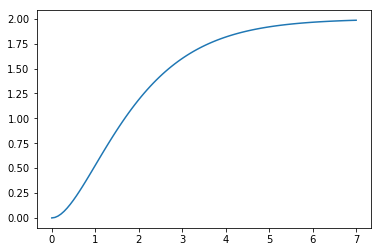

In [4]:
plt.plot(*G.step())

Controller parameters

In [5]:
M = 10  # Control horizon
P = 20  # Prediction horizon
DeltaT = 0.5  # Sampling rate

In [6]:
tcontinuous = numpy.linspace(0, P*DeltaT, 1000)  # some closely spaced time points
tpredict = numpy.arange(0, P*DeltaT, DeltaT)   # discrete points at prediction horizon

In [7]:
u = numpy.ones(M)
r = numpy.ones(P)

We choose a first order setpoint response similar to DS or Dahlin

In [8]:
tau_c = 0.5
r = 1 - numpy.exp(-tpredict/tau_c)

Initital state is zero

In [9]:
x0 = numpy.zeros(G.to_ss().A.shape[0])

In [10]:
def extend(u):
    """We optimise the first M values of u but we need P values for prediction"""
    return numpy.concatenate([u, numpy.repeat(u[-1], P-M)])

In [11]:
def prediction(u, t=tpredict, x0=x0):
    """Predict the effect of an input signal"""
    t, y, x = scipy.signal.lsim(G, u, t, X0=x0, interp=False)
    return y

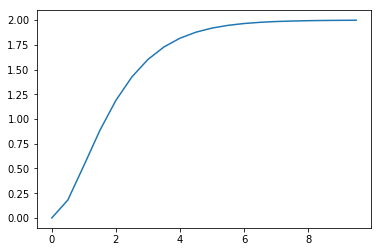

In [12]:
plt.plot(tpredict, prediction(extend(u)))

In [13]:
def objective(u, x0=x0):
    y = prediction(extend(u))
    return sum((r - y)**2)

In [14]:
objective(u)

12.439136839261101

Now we figure out a set of moves which will minimise our objective function

In [25]:
result = scipy.optimize.minimize(objective, u)
uopt = result.x
result.fun

0.24086545207918783

Resample the discrete output to continuous time (effectively work out the 0 order hold value)

In [26]:
ucont = extend(uopt)[((tcontinuous-0.01)//DeltaT).astype(int)]

Plot the move plan and the output. Notice that we are getting exactly the output we want at the sampling times.

In [27]:
def plotoutput(ucont, uopt):
    plt.figure()
    plt.plot(tcontinuous, ucont)
    plt.xlim([0, DeltaT*(P+1)])
    plt.figure()
    plt.plot(tcontinuous, prediction(ucont, tcontinuous), label='Continuous response')
    plt.plot(tpredict, prediction(extend(uopt)), '-o', label='Optimized response')
    plt.plot(tpredict, r, label='Set point')
    plt.legend()

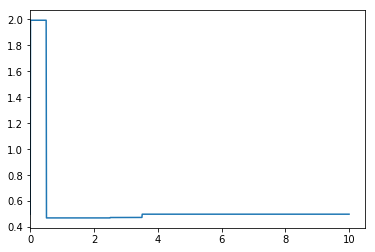

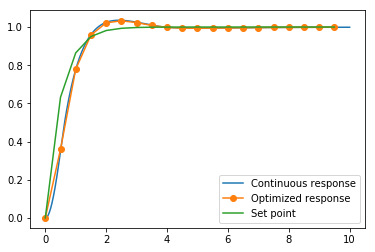

In [28]:
plotoutput(ucont, uopt)

One of the reasons for the popularity of MPC is how easy it is to change its behaviour using weights in the objective function. Try using this definition instead of the simple one above and see if you can remove the ringing in the controller output.

In [24]:
def objective(u, x0=x0):
    y = prediction(extend(u))
    umag = numpy.abs(u)
    constraintpenalty = sum(umag[umag > 2])
    movepenalty = sum(numpy.abs(numpy.diff(u)))
    strongfinish = numpy.abs(y[-1] - r[-1])
    return sum((r - y)**2) + 0*constraintpenalty + 0.1*movepenalty + 0*strongfinish